In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binom
from scipy.ndimage import gaussian_filter

In [109]:
def generate_blob(grid_length:int=50, blob_radius=None, center=None, dimensions_ratio:tuple=None, smoothness:float=0):
    """Generate a single blob with random jitter."""
 
    
    if blob_radius is None:
        typical_value = grid_length/10
        blob_radius = np.random.uniform(0.8*typical_value, 1.2*typical_value)

    if dimensions_ratio is None:
        a, b = np.random.uniform(0.7, 1.2), np.random.uniform(0.7, 1.2)
    else: 
        a, b = dimensions_ratio

    if center is None: 
        center = np.random.randint(blob_radius/2, grid_length - blob_radius/2, size=2)

    y, x = np.ogrid[-center[0]:grid_length-center[0], -center[1]:grid_length-center[1]]

    angle = np.random.uniform(0, 2*np.pi) #orientate randomly the blob
    mask = ((x*np.cos(angle)+y*np.sin(angle))/a)**2 + ((-x*np.sin(angle)+y*np.cos(angle))/b)**2 <= blob_radius**2 
    
    blob = np.zeros((grid_length, grid_length))
    blob[mask] = 1

    # Creating the intensity profile
    distance_from_center = np.sqrt((x * np.cos(angle) + y * np.sin(angle)) ** 2 / a ** 2 +
                                   (-x * np.sin(angle) + y * np.cos(angle)) ** 2 / b ** 2)
    
    intensity = 2*np.exp(-distance_from_center ** 2 / (blob_radius ** 2))  # Gaussian-like profile
    
    blob = np.zeros((grid_length, grid_length))
    blob[mask] = intensity[mask]  # Assign intensity to the blob
    
    return blob


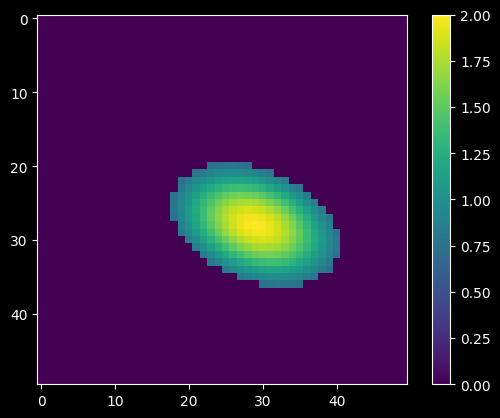

In [116]:
blob = generate_blob(50, 10)
plt.imshow(blob)
plt.colorbar()

In [123]:
def generate_global_map(grid_length:int=50, max_blobs:int=3, jitter:float=0):
    """Generate a spatial map with blobs and jitter."""
        
    map = np.zeros((grid_length, grid_length))

    num_blobs = 0
    while num_blobs == 0: #avoid having blank map
        num_blobs = binom.rvs(n=3, p=0.5, size=1)[0]  # Binomial distribution for number of blobs
    blob_radii = np.random.randint(grid_length//10, (3*grid_length)//10, size=num_blobs)  # Random radius for each blob

    for _ in range(max_blobs):
        blob_radius = np.random.choice(blob_radii)
        center_blob = center = np.random.randint(blob_radius/2, grid_length - blob_radius/2, size=2)
        blob = generate_blob(grid_length=grid_length, blob_radius=blob_radius, center=center_blob, dimensions_ratio=None)
        map += blob  # Add blob to the map

    return map

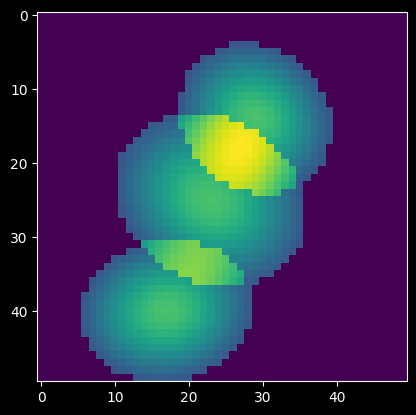

In [125]:
map = generate_global_map(grid_length=50, max_blobs=3, jitter=0)
plt.imshow(map)

In [4]:
def generate_synthetic_fmri_data(subjects, maps_per_subject, time_points, grid_size):
    """Generate synthetic fMRI data for multiple subjects."""
    data = np.zeros((subjects, maps_per_subject, grid_size, grid_size, time_points))

    for subject in range(subjects):
        jitter = np.random.normal(0, 1, 2)  # Gaussian-distributed jitter
        for map_index in range(maps_per_subject):
            spatial_map = generate_global_map(grid_size, max_blobs=3, jitter=jitter)
            for time_point in range(time_points):
                time_series = np.random.rand(grid_size, grid_size)
                noise = gaussian_filter(np.random.randn(grid_size, grid_size), sigma=3)
                data[subject, map_index, :, :, time_point] = spatial_map * time_series + noise

    return data

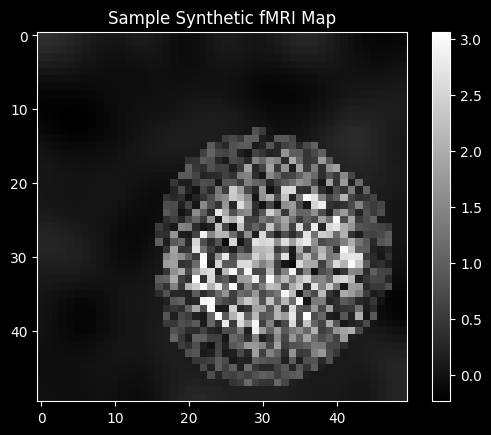

In [2]:


# Parameters
subjects = 12
maps_per_subject = 5
time_points = 150
grid_size = 50

# Generate synthetic fMRI data
synthetic_data = generate_synthetic_fmri_data(subjects, maps_per_subject, time_points, grid_size)

# Visualize one of the generated maps
plt.imshow(synthetic_data[0, 3, :, :, 0], cmap='gray')
plt.title("Sample Synthetic fMRI Map")
plt.colorbar()
plt.show()
